Here we compare the nudging tendencies directly to tendencies achieved from the one-step methodology with all physics on.

We start off by importing the libraries we need and loading two types of data - snapshots of model state at the end of the timestep (including from the coarsened high-res data), and tendencies. Nudging tendencies are output directly by the runfiles while the model is running. Physics tendencies are derived by us here from snapshots before and after physics is called.

**Note: Data can take a long time to load (~tens of minutes)**
Snapshots are mostly lazy-loaded, but contain many files, so the initial load can also take some time. Grid variables are eagerly loaded and take a long time.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import xarray as xr
import fsspec
import zarr
import vcm
import os
import fv3util
import vcm
import cartopy.crs
from datetime import datetime, timedelta

In [29]:
config = yaml.safe_load(open('../fv3config_base.yml', 'r'))
DATA_DIR_TEMPLATE = "gs://vcm-ml-data/mcgibbon-testing/outdir-{}h"
TIMESCALES = [3, 6, 12, 24]
# stages = ['before_dynamics', 'after_dynamics', 'after_physics', 'after_nudging', 'nudging_tendencies', 'reference']
MODEL_STAGE = "after_nudging"
GRID_FILENAME_TEMPLATE = os.path.join(DATA_DIR_TEMPLATE.format(12), 'atmos_8xdaily.tile{}.nc')
RESTARTS_PATH = config['nudging']['restarts_path']
IO_LAYOUT = (1, 1)  # probably only runs for (1, 1)
PLOT_TRANSFORM = cartopy.crs.PlateCarree()

In [6]:
# load snapshot data

def get_timescale_label(timescale):
    if isinstance(timescale, int):
        return f"nudge-{timescale:02d}h"
    else:
        return f"nudge-{timescale:05.2f}"

snapshot = {}
fs, _, _ = fsspec.core.get_fs_token_paths(DATA_DIR_TEMPLATE)
for timescale in TIMESCALES:
    zarr_location = os.path.join(DATA_DIR_TEMPLATE.format(timescale), f"{MODEL_STAGE}.zarr")
    if not fs.isdir(zarr_location):
        raise ValueError(f"location {zarr_location} does not exist")
    snapshot[get_timescale_label(timescale)] = xr.open_zarr(zarr.storage.LRUStoreCache(fs.get_mapper(zarr_location), max_size=None))
zarr_location = os.path.join(DATA_DIR_TEMPLATE.format(timescale), f"reference.zarr")
if not fs.isdir(zarr_location):
    raise ValueError(f"location {zarr_location} does not exist")
snapshot["reference"] = xr.open_zarr(zarr.storage.LRUStoreCache(fs.get_mapper(zarr_location), max_size=None))

In [31]:
# load physics and nudging tendencies

NUDGING_SUFFIX = "_tendency_due_to_nudging"
TIMESTEP = timedelta(minutes=15)
nudging_tendencies = {}
physics_tendencies = {}
for timescale in TIMESCALES:
    nudging = xr.open_zarr(
        zarr.storage.LRUStoreCache(
            fs.get_mapper(
                os.path.join(DATA_DIR_TEMPLATE.format(timescale), "nudging_tendencies.zarr")
            ),
            max_size=None
        )
    )
    rename_dict = {}
    for varname in nudging:
        if varname.endswith(NUDGING_SUFFIX):
            rename_dict[varname] = varname[:-len(NUDGING_SUFFIX)]
    nudging = nudging.rename(rename_dict)
    nudging_tendencies[get_timescale_label(timescale)] = nudging
    
    before_physics = xr.open_zarr(
        zarr.storage.LRUStoreCache(
            fs.get_mapper(
                os.path.join(DATA_DIR_TEMPLATE.format(timescale), "after_dynamics.zarr")
            ),
            max_size=None
        )
    )
    after_physics = xr.open_zarr(
        zarr.storage.LRUStoreCache(
            fs.get_mapper(
                os.path.join(DATA_DIR_TEMPLATE.format(timescale), "after_physics.zarr")
            ),
            max_size=None
        )
    )
    physics = xr.Dataset()
    for varname in nudging:
        if varname != 'time':
            physics[varname] = (after_physics[varname] - before_physics[varname]) / TIMESTEP.total_seconds()
    physics['time'] = before_physics['time']
    physics_tendencies[get_timescale_label(timescale)] = physics

In [8]:
# grid variables (latb in particular) are currently hard to acquire from the running model,
# but easy to grab from the diagnostic files

def load_grid():
    ntime, ntile, nz, ny, nx = snapshot['reference']['air_temperature'].shape
    lat = np.empty([ntile, ny, nx])
    latb = np.empty([ntile, ny+1, nx+1])
    lon = np.empty([ntile, ny, nx])
    lonb = np.empty([ntile, ny+1, nx+1])
    for tile in range(6):
        grid_filename = GRID_FILENAME_TEMPLATE.format(tile+1)
        with fsspec.open(grid_filename, mode='rb') as f:
            ds = xr.open_dataset(f)
            for name in ('lat', 'latb', 'lon', 'lonb'):
                locals()[name][tile, :, :] = ds[name].values
    return lat, lon, latb, lonb

lat, lon, latb, lonb = load_grid()
p = np.cumsum(np.mean(snapshot['reference']['pressure_thickness_of_atmospheric_layer'][0, :, :, :, :].values, axis=(0, 2, 3)))

In [42]:
one_step = xr.open_zarr(zarr.storage.LRUStoreCache(
    fs.get_mapper("gs://vcm-ml-experiments/2020-04-22-advisory-council/physics-on/create_training_data/train/20160806.023000.zarr/"),
    max_size=None
)).isel(initial_time=0)

We see the one-step tendencies (right column, all panels identical) are much larger in magnitude and much noiser than both the nudging tendencies and the physics tendencies of the nudged runs.

air temperature at 850 hPa:

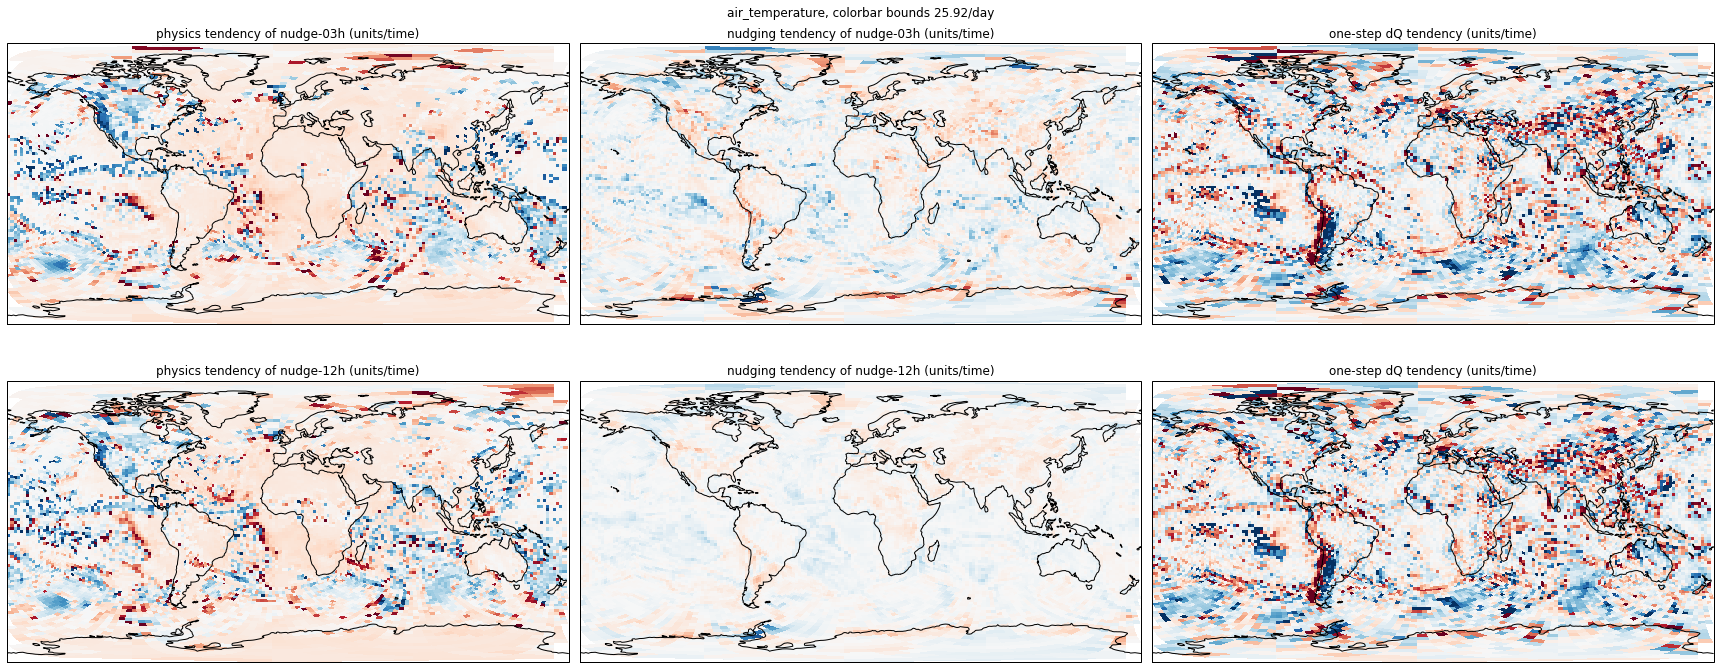

In [65]:
i_time = 5*24*4
i_time = 5*24*4 - 2 + 23 * 4  # days * 24 hours * 4 timesteps per hour
assert snapshot['nudge-03h']["time"][i_time].values == np.datetime64("2016-08-06T23:00:00.000000000"), snapshot['nudge-01h']["time"][i_time].values
assert physics_tendencies['nudge-03h']["time"][i_time].values == np.datetime64("2016-08-06T23:00:00.000000000"), snapshot['nudge-01h']["time"][i_time].values
p_target_hpa = 850
compare_label = get_timescale_label(1)
iz = np.argmin(np.abs(p - p_target_hpa*100))
figsize=(24, 10)
varname = "air_temperature"
one_step_varname = "dQ1"
vmax = 3e-4
vmin = -vmax

K_day = vmax * 60 * 60 * 24

lat_target = -35

plot_keys = ['nudge-03h', 'nudge-12h']

fig, ax = plt.subplots(len(plot_keys), 3, subplot_kw={'projection': PLOT_TRANSFORM}, figsize=figsize)

fig.suptitle(f"{varname} at {p_target_hpa} hPa, colorbar bounds {K_day:.2f}/day")

for i, key in enumerate(sorted(plot_keys)):
    im = vcm.pcolormesh_cube(
        latb, lonb, physics_tendencies[key][varname][i_time, :, iz].values, ax=ax[i, 0], vmin=vmin, vmax=vmax, cmap="RdBu"
    )
    ax[i, 0].set_title(f"physics tendency of {key} (units/time)")
    ax[i, 0].set_global()
    ax[i, 0].coastlines()
    #plt.colorbar(im, ax=ax[i, 0])
    
    im = vcm.pcolormesh_cube(
        latb, lonb, nudging_tendencies[key][varname][i_time, :, iz].values, ax=ax[i, 1], vmin=vmin, vmax=vmax, cmap="RdBu"
    )
    ax[i, 1].set_title(f"nudging tendency of {key} (units/time)")
    ax[i, 1].set_global()
    ax[i, 1].coastlines()
    #plt.colorbar(im, ax=ax[i, 1])

    im = vcm.pcolormesh_cube(
        latb, lonb, one_step[one_step_varname][:, iz].values, ax=ax[i, 2], vmin=vmin, vmax=vmax, cmap="RdBu"
    )
    ax[i, 2].set_title(f"one-step dQ tendency (units/time)")
    ax[i, 2].set_global()
    ax[i, 2].coastlines()
    
plt.tight_layout()
plt.show()

Specific humidity at 850 hPa:

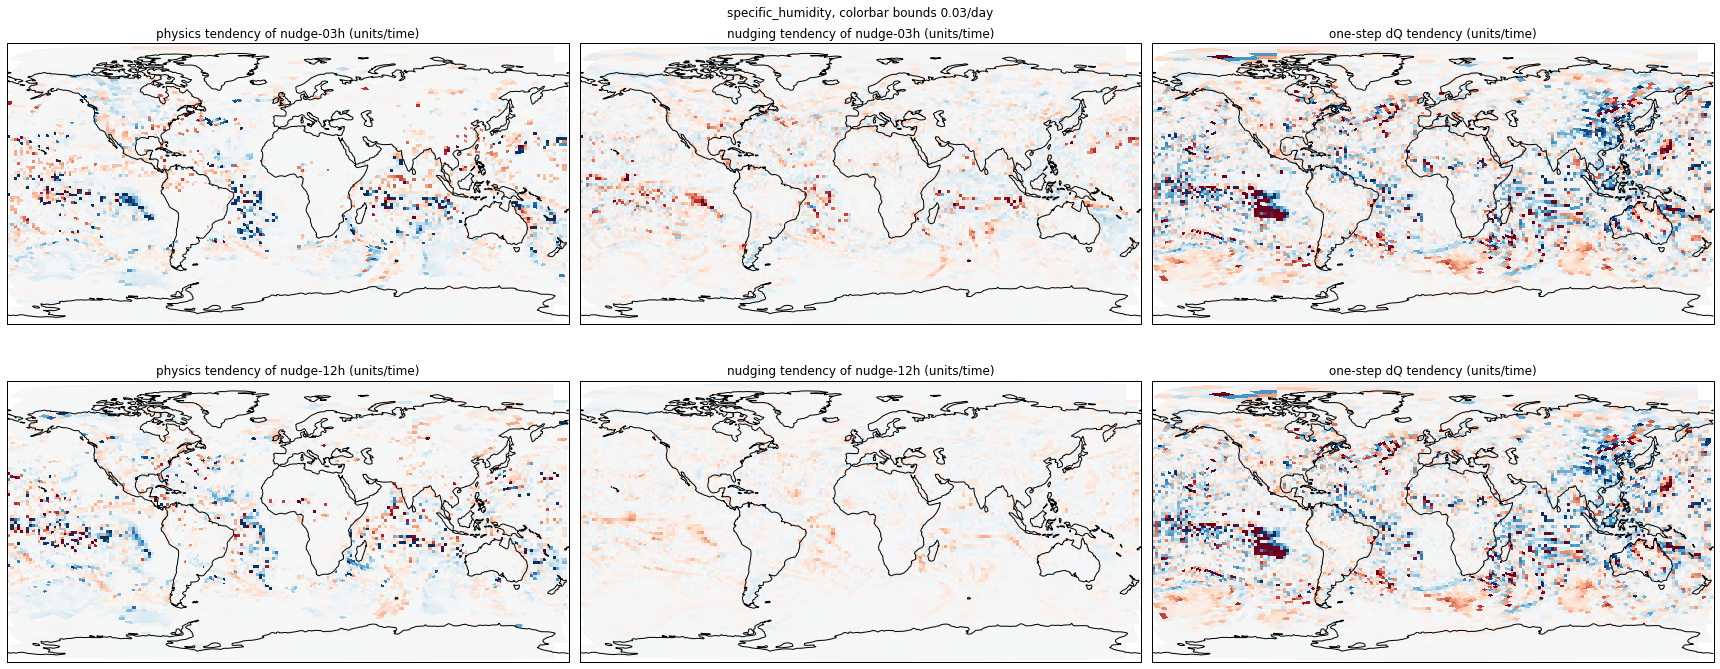

In [67]:
i_time = 5*24*4
i_time = 5*24*4 - 2 + 23 * 4  # days * 24 hours * 4 timesteps per hour
assert snapshot['nudge-03h']["time"][i_time].values == np.datetime64("2016-08-06T23:00:00.000000000"), snapshot['nudge-01h']["time"][i_time].values
assert physics_tendencies['nudge-03h']["time"][i_time].values == np.datetime64("2016-08-06T23:00:00.000000000"), snapshot['nudge-01h']["time"][i_time].values
p_target_hpa = 850
compare_label = get_timescale_label(1)
iz = np.argmin(np.abs(p - p_target_hpa*100))
figsize=(24, 10)
varname = "specific_humidity"
one_step_varname = "dQ2"
vmax = 3e-7
vmin = -vmax

K_day = vmax * 60 * 60 * 24

lat_target = -35

plot_keys = ['nudge-03h', 'nudge-12h']

fig, ax = plt.subplots(len(plot_keys), 3, subplot_kw={'projection': PLOT_TRANSFORM}, figsize=figsize)

fig.suptitle(f"{varname} at {p_target_hpa} hPa, colorbar bounds {K_day:.2f}/day")

for i, key in enumerate(sorted(plot_keys)):
    im = vcm.pcolormesh_cube(
        latb, lonb, physics_tendencies[key][varname][i_time, :, iz].values, ax=ax[i, 0], vmin=vmin, vmax=vmax, cmap="RdBu"
    )
    ax[i, 0].set_title(f"physics tendency of {key} (units/time)")
    ax[i, 0].set_global()
    ax[i, 0].coastlines()
    #plt.colorbar(im, ax=ax[i, 0])
    
    im = vcm.pcolormesh_cube(
        latb, lonb, nudging_tendencies[key][varname][i_time, :, iz].values, ax=ax[i, 1], vmin=vmin, vmax=vmax, cmap="RdBu"
    )
    ax[i, 1].set_title(f"nudging tendency of {key} (units/time)")
    ax[i, 1].set_global()
    ax[i, 1].coastlines()
    #plt.colorbar(im, ax=ax[i, 1])

    im = vcm.pcolormesh_cube(
        latb, lonb, one_step[one_step_varname][:, iz].values, ax=ax[i, 2], vmin=vmin, vmax=vmax, cmap="RdBu"
    )
    ax[i, 2].set_title(f"one-step dQ tendency (units/time)")
    ax[i, 2].set_global()
    ax[i, 2].coastlines()
    
plt.tight_layout()
plt.show()

Looking at column-integrated values, the behavior is more glaringly apparent.

Air temperature:

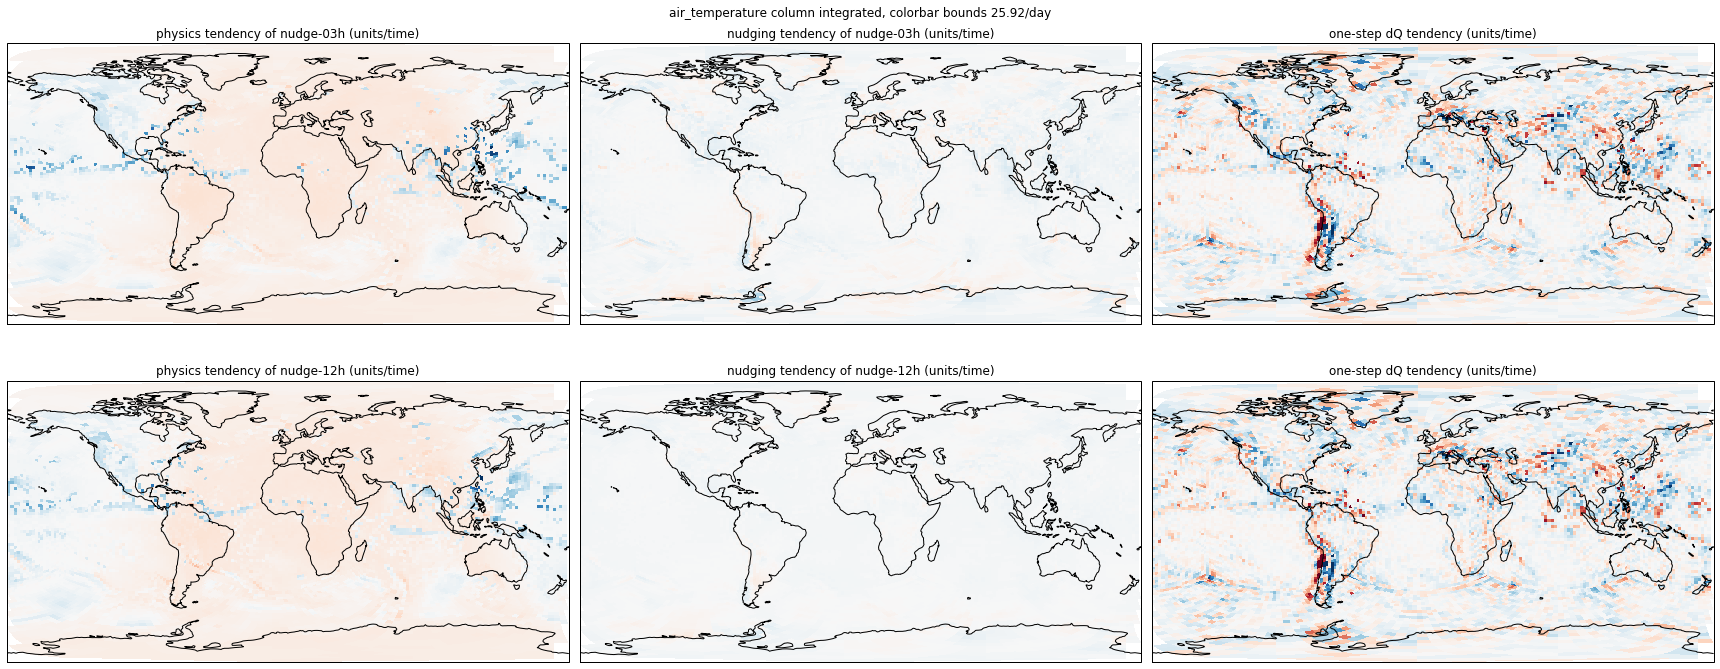

In [71]:
i_time = 5*24*4
i_time = 5*24*4 - 2 + 23 * 4  # days * 24 hours * 4 timesteps per hour
assert snapshot['nudge-03h']["time"][i_time].values == np.datetime64("2016-08-06T23:00:00.000000000"), snapshot['nudge-01h']["time"][i_time].values
assert physics_tendencies['nudge-03h']["time"][i_time].values == np.datetime64("2016-08-06T23:00:00.000000000"), snapshot['nudge-01h']["time"][i_time].values
p_target_hpa = 850
compare_label = get_timescale_label(1)
iz = np.argmin(np.abs(p - p_target_hpa*100))
figsize=(24, 10)
varname = "air_temperature"
one_step_varname = "dQ1"
vmax = 3e-4
vmin = -vmax

K_day = vmax * 60 * 60 * 24

lat_target = -35

plot_keys = ['nudge-03h', 'nudge-12h']


dp = snapshot['reference']['pressure_thickness_of_atmospheric_layer'][i_time, :, :, :, :].values
p_surface = np.sum(dp, axis=1)

def column_integrate(array):
    return np.sum(array * dp, axis=1) / p_surface

fig, ax = plt.subplots(len(plot_keys), 3, subplot_kw={'projection': PLOT_TRANSFORM}, figsize=figsize)

fig.suptitle(f"{varname} column integrated, colorbar bounds {K_day:.2f}/day")

for i, key in enumerate(sorted(plot_keys)):
    im = vcm.pcolormesh_cube(
        latb, lonb, column_integrate(physics_tendencies[key][varname][i_time, :].values), ax=ax[i, 0], vmin=vmin, vmax=vmax, cmap="RdBu"
    )
    ax[i, 0].set_title(f"physics tendency of {key} (units/time)")
    ax[i, 0].set_global()
    ax[i, 0].coastlines()
    #plt.colorbar(im, ax=ax[i, 0])
    
    im = vcm.pcolormesh_cube(
        latb, lonb, column_integrate(nudging_tendencies[key][varname][i_time, :].values), ax=ax[i, 1], vmin=vmin, vmax=vmax, cmap="RdBu"
    )
    ax[i, 1].set_title(f"nudging tendency of {key} (units/time)")
    ax[i, 1].set_global()
    ax[i, 1].coastlines()
    #plt.colorbar(im, ax=ax[i, 1])

    im = vcm.pcolormesh_cube(
        latb, lonb, column_integrate(one_step[one_step_varname].values), ax=ax[i, 2], vmin=vmin, vmax=vmax, cmap="RdBu"
    )
    ax[i, 2].set_title(f"one-step dQ tendency (units/time)")
    ax[i, 2].set_global()
    ax[i, 2].coastlines()
    
plt.tight_layout()
plt.show()

Column integrated specific humidity:

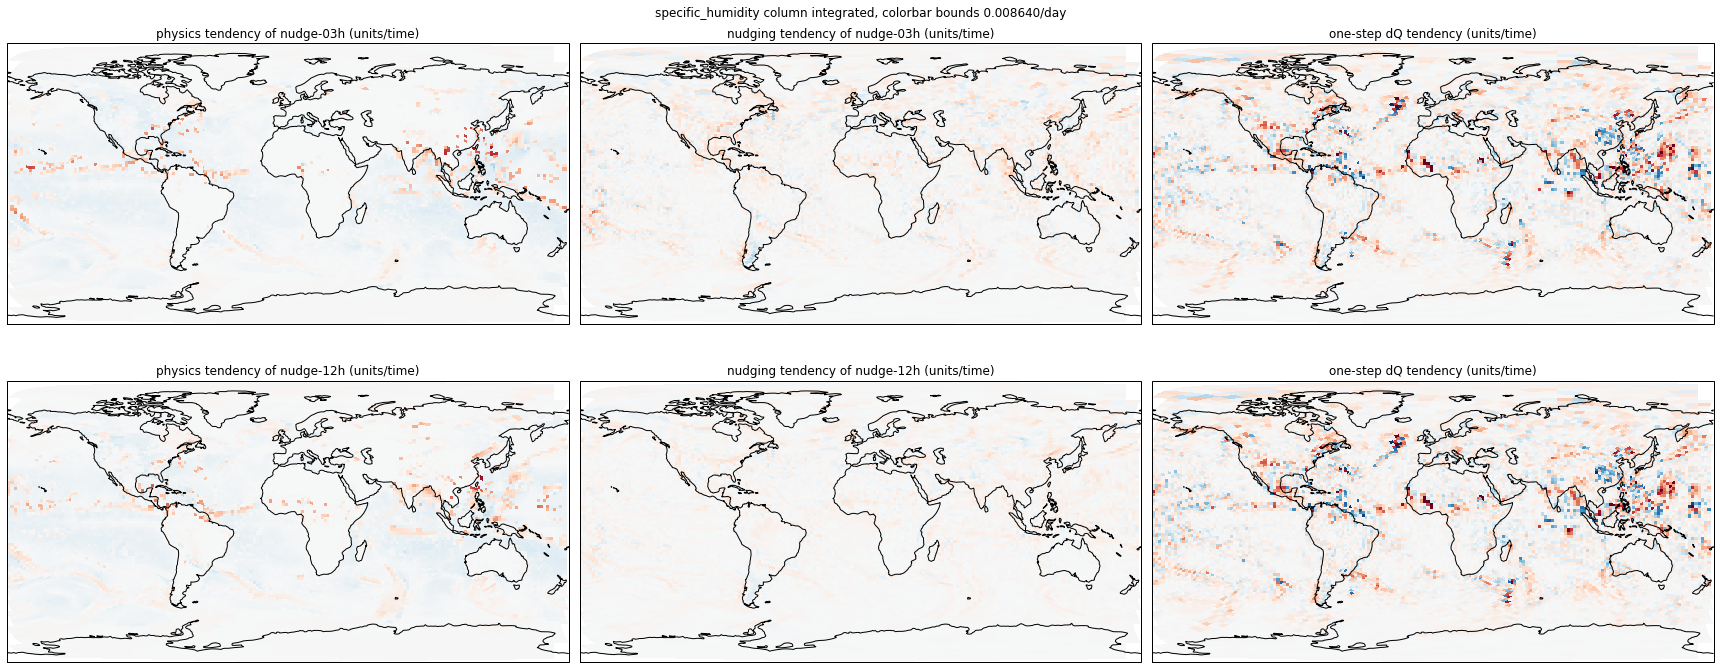

In [74]:
i_time = 5*24*4
i_time = 5*24*4 - 2 + 23 * 4  # days * 24 hours * 4 timesteps per hour
assert snapshot['nudge-03h']["time"][i_time].values == np.datetime64("2016-08-06T23:00:00.000000000"), snapshot['nudge-01h']["time"][i_time].values
assert physics_tendencies['nudge-03h']["time"][i_time].values == np.datetime64("2016-08-06T23:00:00.000000000"), snapshot['nudge-01h']["time"][i_time].values
p_target_hpa = 850
compare_label = get_timescale_label(1)
iz = np.argmin(np.abs(p - p_target_hpa*100))
figsize=(24, 10)
varname = "specific_humidity"
one_step_varname = "dQ2"
vmax = 1e-7
vmin = -vmax

K_day = vmax * 60 * 60 * 24

lat_target = -35

plot_keys = ['nudge-03h', 'nudge-12h']


dp = snapshot['reference']['pressure_thickness_of_atmospheric_layer'][i_time, :, :, :, :].values
p_surface = np.sum(dp, axis=1)

def column_integrate(array):
    return np.sum(array * dp, axis=1) / p_surface

fig, ax = plt.subplots(len(plot_keys), 3, subplot_kw={'projection': PLOT_TRANSFORM}, figsize=figsize)

fig.suptitle(f"{varname} column integrated, colorbar bounds {K_day:.6f}/day")

for i, key in enumerate(sorted(plot_keys)):
    im = vcm.pcolormesh_cube(
        latb, lonb, column_integrate(physics_tendencies[key][varname][i_time, :].values), ax=ax[i, 0], vmin=vmin, vmax=vmax, cmap="RdBu"
    )
    ax[i, 0].set_title(f"physics tendency of {key} (units/time)")
    ax[i, 0].set_global()
    ax[i, 0].coastlines()
    #plt.colorbar(im, ax=ax[i, 0])
    
    im = vcm.pcolormesh_cube(
        latb, lonb, column_integrate(nudging_tendencies[key][varname][i_time, :].values), ax=ax[i, 1], vmin=vmin, vmax=vmax, cmap="RdBu"
    )
    ax[i, 1].set_title(f"nudging tendency of {key} (units/time)")
    ax[i, 1].set_global()
    ax[i, 1].coastlines()
    #plt.colorbar(im, ax=ax[i, 1])

    im = vcm.pcolormesh_cube(
        latb, lonb, column_integrate(one_step[one_step_varname].values), ax=ax[i, 2], vmin=vmin, vmax=vmax, cmap="RdBu"
    )
    ax[i, 2].set_title(f"one-step dQ tendency (units/time)")
    ax[i, 2].set_global()
    ax[i, 2].coastlines()
    
plt.tight_layout()
plt.show()

Let's plot specific humidity again, but with a smaller colorbar to show the nudging tendency features

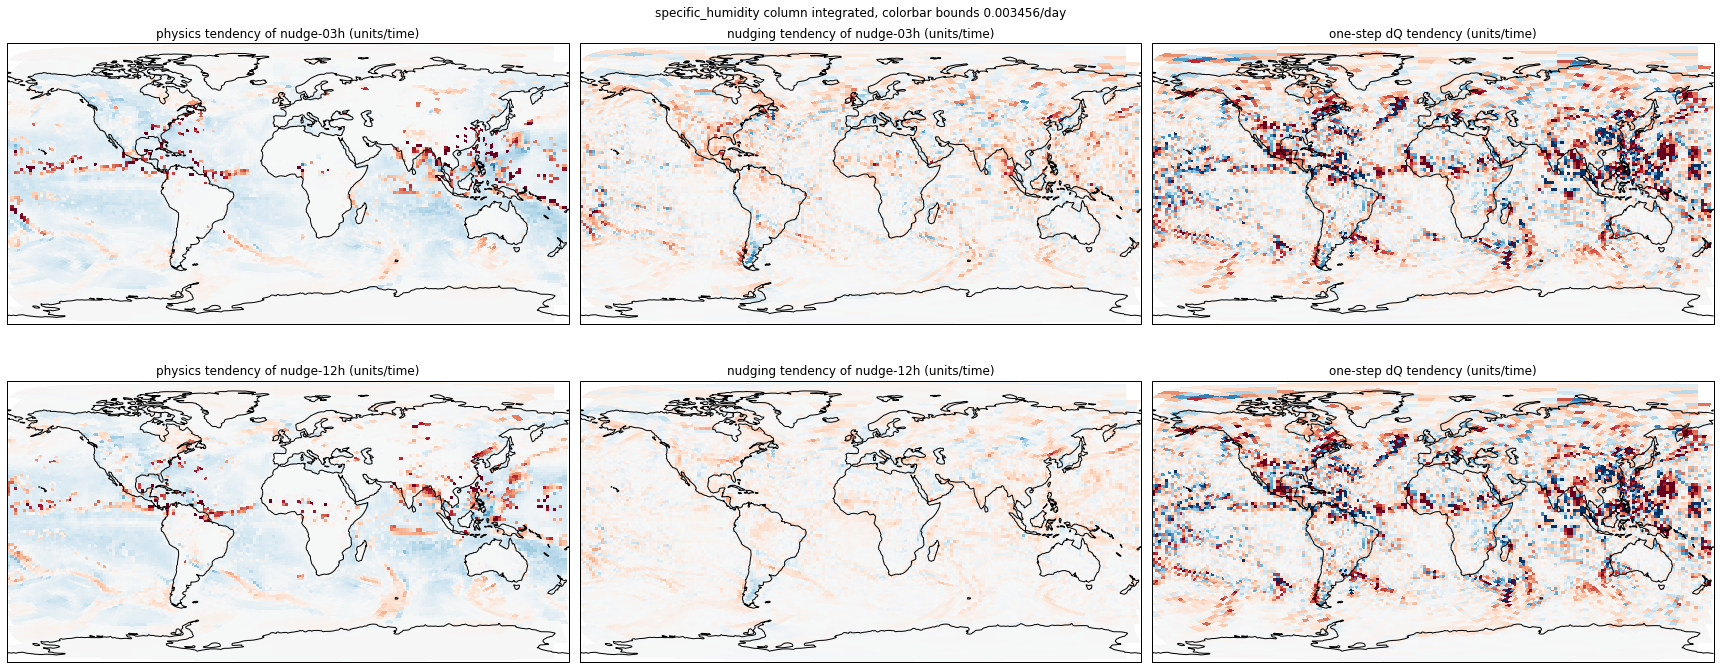

In [77]:
i_time = 5*24*4
i_time = 5*24*4 - 2 + 23 * 4  # days * 24 hours * 4 timesteps per hour
assert snapshot['nudge-03h']["time"][i_time].values == np.datetime64("2016-08-06T23:00:00.000000000"), snapshot['nudge-01h']["time"][i_time].values
assert physics_tendencies['nudge-03h']["time"][i_time].values == np.datetime64("2016-08-06T23:00:00.000000000"), snapshot['nudge-01h']["time"][i_time].values
p_target_hpa = 850
compare_label = get_timescale_label(1)
iz = np.argmin(np.abs(p - p_target_hpa*100))
figsize=(24, 10)
varname = "specific_humidity"
one_step_varname = "dQ2"
vmax = 4e-8
vmin = -vmax

K_day = vmax * 60 * 60 * 24

lat_target = -35

plot_keys = ['nudge-03h', 'nudge-12h']


dp = snapshot['reference']['pressure_thickness_of_atmospheric_layer'][i_time, :, :, :, :].values
p_surface = np.sum(dp, axis=1)

def column_integrate(array):
    return np.sum(array * dp, axis=1) / p_surface

fig, ax = plt.subplots(len(plot_keys), 3, subplot_kw={'projection': PLOT_TRANSFORM}, figsize=figsize)

fig.suptitle(f"{varname} column integrated, colorbar bounds {K_day:.6f}/day")

for i, key in enumerate(sorted(plot_keys)):
    im = vcm.pcolormesh_cube(
        latb, lonb, column_integrate(physics_tendencies[key][varname][i_time, :].values), ax=ax[i, 0], vmin=vmin, vmax=vmax, cmap="RdBu"
    )
    ax[i, 0].set_title(f"physics tendency of {key} (units/time)")
    ax[i, 0].set_global()
    ax[i, 0].coastlines()
    #plt.colorbar(im, ax=ax[i, 0])
    
    im = vcm.pcolormesh_cube(
        latb, lonb, column_integrate(nudging_tendencies[key][varname][i_time, :].values), ax=ax[i, 1], vmin=vmin, vmax=vmax, cmap="RdBu"
    )
    ax[i, 1].set_title(f"nudging tendency of {key} (units/time)")
    ax[i, 1].set_global()
    ax[i, 1].coastlines()
    #plt.colorbar(im, ax=ax[i, 1])

    im = vcm.pcolormesh_cube(
        latb, lonb, column_integrate(one_step[one_step_varname].values), ax=ax[i, 2], vmin=vmin, vmax=vmax, cmap="RdBu"
    )
    ax[i, 2].set_title(f"one-step dQ tendency (units/time)")
    ax[i, 2].set_global()
    ax[i, 2].coastlines()
    
plt.tight_layout()
plt.show()